This notebook walks through some of the functionality of ebms_mcm code.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from ebms_mcmc.gen_data.generate_toy_data import gen_toy_data
from ebms_mcmc.mcmc.mcmc import MCMC
from ebms_mcmc.evidence_calc.polynomials import Polynomials 
from ebms_mcmc.eval.plotting import Plotting
from ebms_mcmc import default_params

First, we generate toy data given a true model: $y = -0.3-0.5x+0.9x^3$  
The parameters are then a np.array with length 3 and the binary specification is [1,1,0,0].  
We need to add a noise scale, the width of Gaussian, and how many points we want.

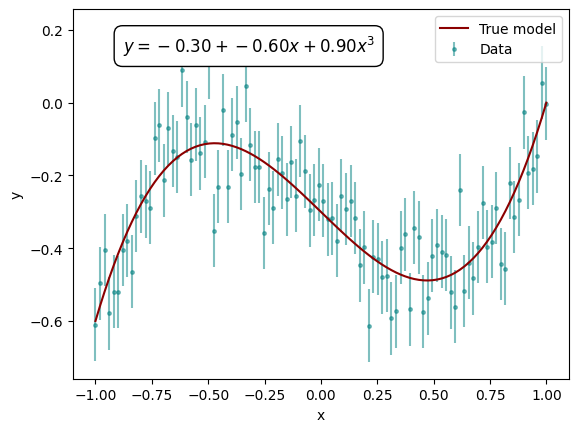

In [2]:
poly_params = np.array([-0.3, -0.6, 0.9 ])
binary_model = [1, 1, 0, 1]
noise_scale = 0.1
num_points = 100
# override default params
gen_settings = {**default_params['data']['params'],
                **{'params': poly_params, 'bin': binary_model}}

# simualate data
data, _, _ = gen_toy_data(num_points=num_points,
                          noise_scale=noise_scale,
                          params=gen_settings,
                          name='data/',
                          plot=True)

The data is saved as a .npz file with the keys `x_data`, `y_data`, `y_err`, `params` and `bin`.  
If external data is used for the model selection, the necessary keys are: 
- `x_data`  
- `y_data`
- `y_err` or `cov`

With this data we can infer the model posterior. We need to give at least where the data is stored and give a function to calculate the evidence.

In [3]:
mcmc_params = {**default_params['run'],**{'data_path' : 'data/toy_data.npz'}}
log_evidence_func = Polynomials(mcmc_params).log_evidence
mcmc_class = MCMC(mcmc_params)
mcmc_class.run(log_evidence_func)

Now we can evaluate and plot our results

In [4]:
# set up the plotter
plot_params = {**default_params['plot'], **{'plot_dir' : 'run/plots/'}}
plot = Plotting(plot_params)


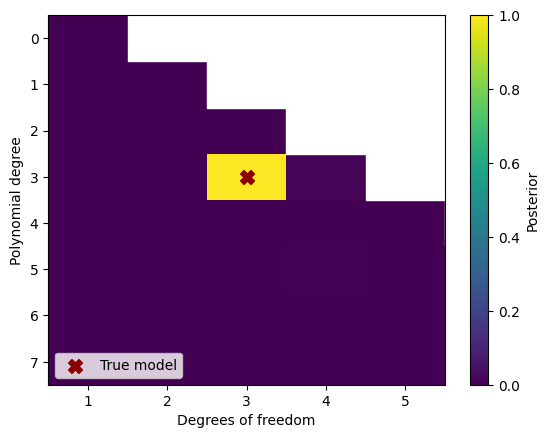

----------------
Model	Posterior
----------------
[1 1 0 1 0 0 0 0]	0.9782527449217685
[1 1 1 1 0 0 0 0]	0.009464550863122595
[1 1 0 1 0 1 0 0]	0.005545398531327966
[1 1 0 1 1 0 0 0]	0.003343400571711397
[1 1 0 0 0 1 0 0]	0.002474722477550732
[1 1 1 1 1 0 0 0]	0.00029292633407743357
[1 1 1 1 0 1 0 0]	0.00016161452914617024
[1 1 0 1 0 0 0 1]	0.0001515136210745346
[1 1 0 1 1 1 0 0]	7.070635650144948e-05
[1 1 0 1 0 0 1 0]	7.070635650144948e-05
[1 1 0 0 1 1 0 0]	7.070635650144948e-05
[1 1 1 0 0 1 0 0]	6.060544842981384e-05
[1 1 0 1 0 1 1 0]	4.040363228654256e-05
----------------


In [5]:
plot.visualise_chain_2d_color()
plot.save_posterior_list(print_list=True)

So far, we have only used the default settings. Most importantly, this includes a Gaussian parameter prior and a specific model prior. Next, we show how to use different priors

In [6]:
mcmc_params_model_priors = {**default_params['run'],
                            **{'name' : 'run1/',
                               'data_path' : 'data/toy_data.npz',
                               'prior_kind' : 'uniform',  #model prior
                               'param_prior' : 'gaussian', #for uniform prior, multinest must be installed
                               'prior_gaussian_mean': 3, #mean of the gaussian prior
                               'prior_gaussian_inv_cov': 1 #inverse covariance of the gaussian prior
                               }}
log_evidence_func_priors = Polynomials(mcmc_params_model_priors).log_evidence
mcmc_class_priors = MCMC(mcmc_params)
mcmc_class_priors.run(log_evidence_func_priors)

We can check if it had any effect on the posterior

In [7]:
plot_params_prior = {**default_params['plot'], **{'plot_dir' : 'run1/plots/'}}
plot_prior = Plotting(plot_params)

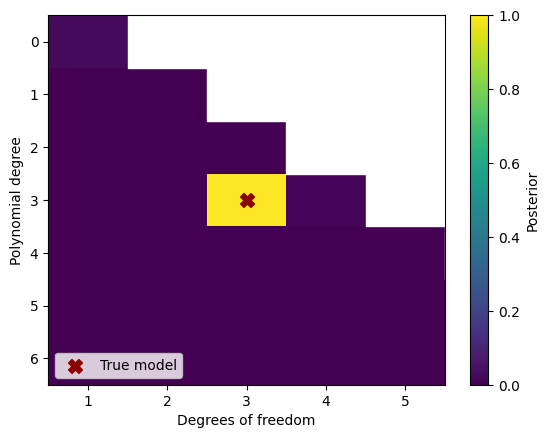

----------------
Model	Posterior
----------------
[1 1 0 1 0 0 0 0]	0.9581317360430702
[1 0 0 0 0 0 0 0]	0.02566640741002616
[1 1 1 1 0 0 0 0]	0.008181735538024868
[1 1 0 1 1 0 0 0]	0.002949465156917607
[1 1 0 1 0 1 0 0]	0.002616135190553631
[1 1 0 0 0 1 0 0]	0.0017474570963929657
[1 1 0 0 0 0 0 0]	0.0004949444955101464
[1 1 0 1 0 0 1 0]	0.0001010090807163564
[1 1 0 0 1 1 0 0]	8.080726457308512e-05
[1 1 0 1 1 1 0 0]	2.020181614327128e-05
[1 0 1 0 0 0 0 0]	1.010090807163564e-05
----------------


In [8]:
plot_prior.visualise_chain_2d_color()
plot_prior.save_posterior_list(print_list=True)

There are many more features, like plotting and prior settings. Please check out the source code and the param files. For the tutorial on the CLI usage, please see the Github. Note, that when the evidence is note analytically calcable, Multinest needs to be installed and only the CLI interface works.